# Análise de agrupamento em Python 🐍

## Obtendo os dados

Para exemplificar o algoritmo de agrupamento por k-médias será usado o conjunto de dados `mpg` disponível na biblioteca *Seaborn*. Este conjunto de dados O conjunto de dados apresenta iformações sobre ostra dados de `398` veículos com 9 variáveis:

* **mpg** - consumo em milhas por galão (`9.0` a `46.6`).
* **cylinders** - número de cilindros no motor (`3` a `8`).
* **displacement** - volume dos cilindros em polegadas cúbicas (`68` a `455`).
* **horsepower** - potência em HP (`46` a `230`).
* **weight** - peso do veículo em libras (`1613` a `5140`).
* **acceleration** - tempo de aceleração em segundos até 60 milhas por hora (`8.0` a `24.8`).
* **model_year** - ano do modelo (`1970` a `1982`).
* **origin** - país de origem.
* **name** - nome do modelo.

Para exemplificar o método de agrupamento por k-Médias, neste tutorial, será usado apenas 3 variáveis: **mpg**, **horsepower** e **weigth**. O objetivo é formar grupos de modelos por semelhança com relação à estes 3 parâmetros.



In [1]:
import seaborn as sns
dt = sns.load_dataset('mpg')
dt.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


Para preparar os dados para o nosso algoritmo seram criados dos objetos do *NumPy*: `X` contendo as variáveis de interesse e `Y` contendo os nomes dos modelos.

In [2]:
import numpy as np
dts = dt[['mpg', 'horsepower', 'weight', 'name']]

## O método k-médias

O **agrupamento por k-médias** é um método não paramétrico (não baseado na distribuição das variáveis) que consiste no seguinte algoritmo:

1.   Os elementos amostrais são distribuídos em $k \geq 2$ grupos ao acaso.
2.   Para cada um dos $k$ grupos formados calcula-se o centroide (coordenada formada pela média de cada uma das variáveis para os elementos do grupo);
3.   Para cada elemento amostral, calcula-se a distância (euclidiana) entre o elemento e o centroide de cada grupo.
4.   Se o elemento de um grupo estiver mais próximo do centroide de outro grupo, desloca-se este elemento amostral para grupo com a menor distância e recalcula-se os centroides dos grupos de origem e destino (o recálculo ocorre elemento a elemento).
5.   Enquanto for possível fazer trocas entre os elementos, repete-se os passos (3) e (4).
6.   Quando não for mais possível fazer trocas, interrompe-se o algoritmo e o resultado final é obtido.

O algoritmo será demonstrado de forma manual com um subconjunto de 30 veículos e, posteriormente, o k-médias será aplicado ao conjunto de dados original.

### Executando o k-médias manualmente (tutorial)

Para iniciar o estudo do algoritmo considere o conjunto formado pelas 30 observações iniciais do conjunto de dados:

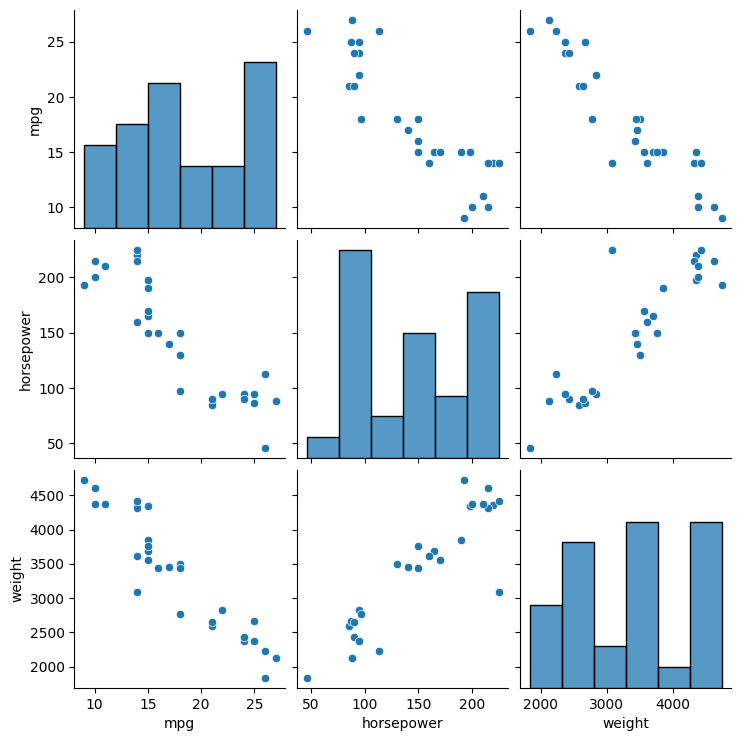

In [12]:
dtss = dts[0:30]
sns.pairplot(dtss);

O primeiro passo do algoritmo consiste em separar os elementos em $k$ grupos. Para efeito de demonstração do algoritmo considere $k = 3$. A separação inicial pode ser feita ao acaso ou com algum critério. Iremos separar os 10 primeiros elementos no grupo `1`, os 10 próximos elementos no grupo `2` e os 10 elementos restantes no grupo `3`.

In [13]:
dtss = dtss.assign(group= lambda x: 1)
dtss.loc[0:9, 'group'] = 1
dtss.loc[10:19, 'group'] = 2
dtss.loc[20:29, 'group'] = 3
dtss

,mpg,horsepower,weight,name,group
0,18.0,130.0,3504,chevrolet chevelle malibu,1
1,15.0,165.0,3693,buick skylark 320,1
2,18.0,150.0,3436,plymouth satellite,1
3,16.0,150.0,3433,amc rebel sst,1
4,17.0,140.0,3449,ford torino,1
5,15.0,198.0,4341,ford galaxie 500,1
6,14.0,220.0,4354,chevrolet impala,1
7,14.0,215.0,4312,plymouth fury iii,1
8,14.0,225.0,4425,pontiac catalina,1
9,15.0,190.0,3850,amc ambassador dpl,1


O objetivo dos métodos de agrupamento é criar grupos que sejam o mais heterogêneo possível, e seus elementos devem ser o mais homogêneos possível.

Evidentemente, o agrupamento inicial não gera um bom resultado. Basta ver que a distribuição dos 3 grupos (representado pelas 3 cores no gráfico) são sobrepostas em todas as variáveis.

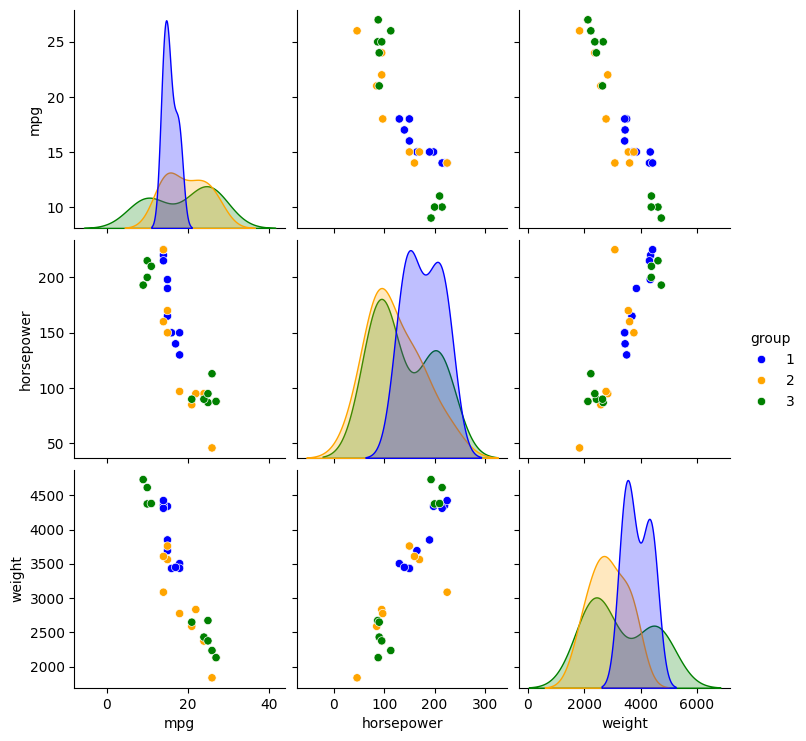

In [14]:
sns.pairplot(dtss, hue= 'group', palette= { 1: 'blue', 2: 'orange', 3: 'green'});

In [15]:
c1 = dtss.loc[dtss['group'] == 1, ['mpg', 'horsepower', 'weight']].mean()
c2 = dtss.loc[dtss['group'] == 2, ['mpg', 'horsepower', 'weight']].mean()
c3 = dtss.loc[dtss['group'] == 3, ['mpg', 'horsepower', 'weight']].mean()

print(f"O centroide do grupo 1 é: mpg = {c1['mpg']:.1f}, hp = {c1['horsepower']:.1f} e weight = {c1['weight']:.1f}.")
print(f"O centroide do grupo 2 é: mpg = {c2['mpg']:.1f}, hp = {c2['horsepower']:.1f} e weight = {c2['weight']:.1f}.")
print(f"O centroide do grupo 3 é: mpg = {c3['mpg']:.1f}, hp = {c3['horsepower']:.1f} e weight = {c3['weight']:.1f}.")

O centroide do grupo 1 é: mpg = 15.6, hp = 178.3 e weight = 3879.7.
O centroide do grupo 2 é: mpg = 19.6, hp = 121.1 e weight = 2855.0.
O centroide do grupo 3 é: mpg = 18.8, hp = 138.1 e weight = 3259.4.


O próximo passo é calcular a distância de cada observação para os centroides. Por exemplo, tomando a primeira observação (posição `0`) obtém-se:

In [16]:
import math

d1 = math.sqrt(np.sum((dtss.loc[0,['mpg', 'horsepower', 'weight']] - c1) ** 2))
d2 = math.sqrt(np.sum((dtss.loc[0,['mpg', 'horsepower', 'weight']] - c2) ** 2))
d3 = math.sqrt(np.sum((dtss.loc[0,['mpg', 'horsepower', 'weight']] - c3) ** 2))

print(f"A distância da observação 0 para o centroide do grupo 1 é {d1:.4f}.")
print(f"A distância da observação 0 para o centroide do grupo 2 é {d2:.4f}.")
print(f"A distância da observação 0 para o centroide do grupo 3 é {d3:.4f}.")

A distância da observação 0 para o centroide do grupo 1 é 378.7996.
A distância da observação 0 para o centroide do grupo 2 é 649.0630.
A distância da observação 0 para o centroide do grupo 3 é 244.7354.


Observe que a observação **pertence ao grupo 1**, porém, **está mais próxima do centroide do grupo 3**. Logo esta observação precisa mudar para o grupo 3.

In [17]:
dtss.loc[0, 'group'] = 3

Após relocar o elemento, calcula-se novamente os centroides.

In [18]:
c1 = dtss.loc[dtss['group'] == 1, ['mpg', 'horsepower', 'weight']].mean()
c2 = dtss.loc[dtss['group'] == 2, ['mpg', 'horsepower', 'weight']].mean()
c3 = dtss.loc[dtss['group'] == 3, ['mpg', 'horsepower', 'weight']].mean()

print(f"O centroide do grupo 1 é: mpg = {c1['mpg']:.1f}, hp = {c1['horsepower']:.1f} e weight = {c1['weight']:.1f}.")
print(f"O centroide do grupo 2 é: mpg = {c2['mpg']:.1f}, hp = {c2['horsepower']:.1f} e weight = {c2['weight']:.1f}.")
print(f"O centroide do grupo 3 é: mpg = {c3['mpg']:.1f}, hp = {c3['horsepower']:.1f} e weight = {c3['weight']:.1f}.")

O centroide do grupo 1 é: mpg = 15.3, hp = 183.7 e weight = 3921.4.
O centroide do grupo 2 é: mpg = 19.6, hp = 121.1 e weight = 2855.0.
O centroide do grupo 3 é: mpg = 18.7, hp = 137.4 e weight = 3281.6.


O processo é repetido para as demais observações.

In [19]:
for k in range(1, 30):
  d1 = math.sqrt(np.sum((dtss.loc[k, ['mpg', 'horsepower', 'weight']] - c1) ** 2))
  d2 = math.sqrt(np.sum((dtss.loc[k, ['mpg', 'horsepower', 'weight']] - c2) ** 2))
  d3 = math.sqrt(np.sum((dtss.loc[k, ['mpg', 'horsepower', 'weight']] - c3) ** 2))

  if np.argmin(np.array([d1, d2, d3])) + 1 != dtss.loc[k, 'group']:
    dtss.loc[k, 'group'] = np.argmin(np.array([d1, d2, d3])) + 1

    c1 = dtss.loc[dtss['group'] == 1, ['mpg', 'horsepower', 'weight']].mean()
    c2 = dtss.loc[dtss['group'] == 2, ['mpg', 'horsepower', 'weight']].mean()
    c3 = dtss.loc[dtss['group'] == 3, ['mpg', 'horsepower', 'weight']].mean()

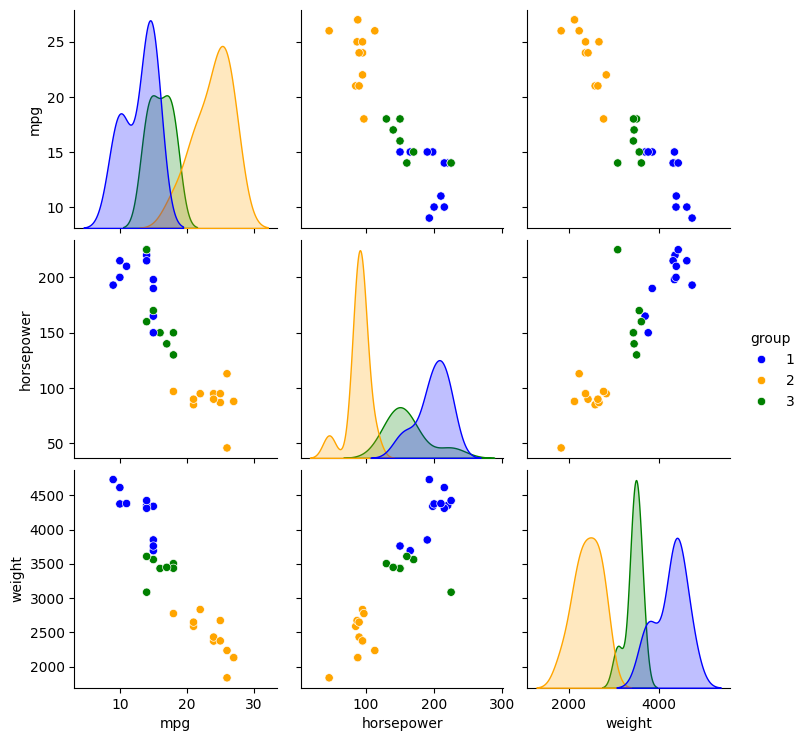

In [20]:
sns.pairplot(dtss, hue= 'group', palette= { 1: 'blue', 2: 'orange', 3: 'green'});

Observe que o grupo 2 (laranja) já se destaca mais dos outros grupos com apenas uma sequência de trocas dos elementos por grupos. O grupo laranja é composto por veículos com menor potência, menor consumo e menor peso.

O algoritmo se repete enquanto ainda existir alguma substituição para se fazer:

In [21]:
while True:
  changed = False
  for k in range(30):
    d1 = math.sqrt(np.sum((dtss.loc[k, ['mpg', 'horsepower', 'weight']] - c1) ** 2))
    d2 = math.sqrt(np.sum((dtss.loc[k, ['mpg', 'horsepower', 'weight']] - c2) ** 2))
    d3 = math.sqrt(np.sum((dtss.loc[k, ['mpg', 'horsepower', 'weight']] - c3) ** 2))

    if np.argmin(np.array([d1, d2, d3])) + 1 != dtss.loc[k, 'group']:
      dtss.loc[k, 'group'] = np.argmin(np.array([d1, d2, d3])) + 1

      c1 = dtss.loc[dtss['group'] == 1, ['mpg', 'horsepower', 'weight']].mean()
      c2 = dtss.loc[dtss['group'] == 2, ['mpg', 'horsepower', 'weight']].mean()
      c3 = dtss.loc[dtss['group'] == 3, ['mpg', 'horsepower', 'weight']].mean()

      changed = True

  if not changed:
    break

O resultado final são 3 grupos o mais heterogêneo possível: o grupo 1 (azul) são compostos de automóveis mais exportivos (maior consumo, maior potência e maior peso) o grupo 2 (laranja) são os caros mais tradicionais (menor consumo, menor potência e menor peso) e o grupo 3 (verde) é uma classe intermediária.

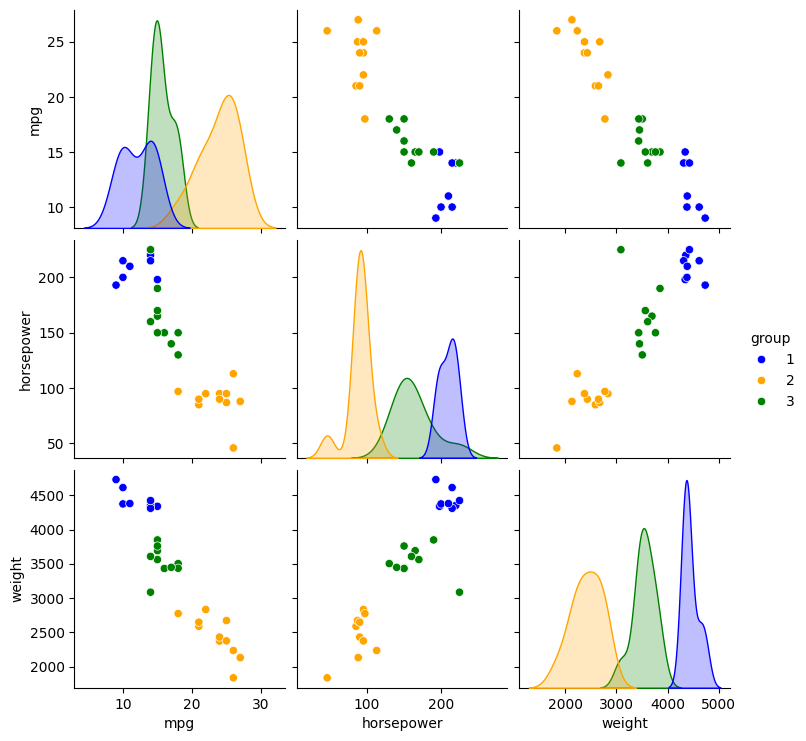

In [22]:
sns.pairplot(dtss, hue= 'group', palette= { 1: 'blue', 2: 'orange', 3: 'green'});

## Realizando o agrupamento em toda a base

O conjunto completo de dados é composto por `398` veículos. A distribuição das variáveis de interesse está mostrada no gráfico abaixo.

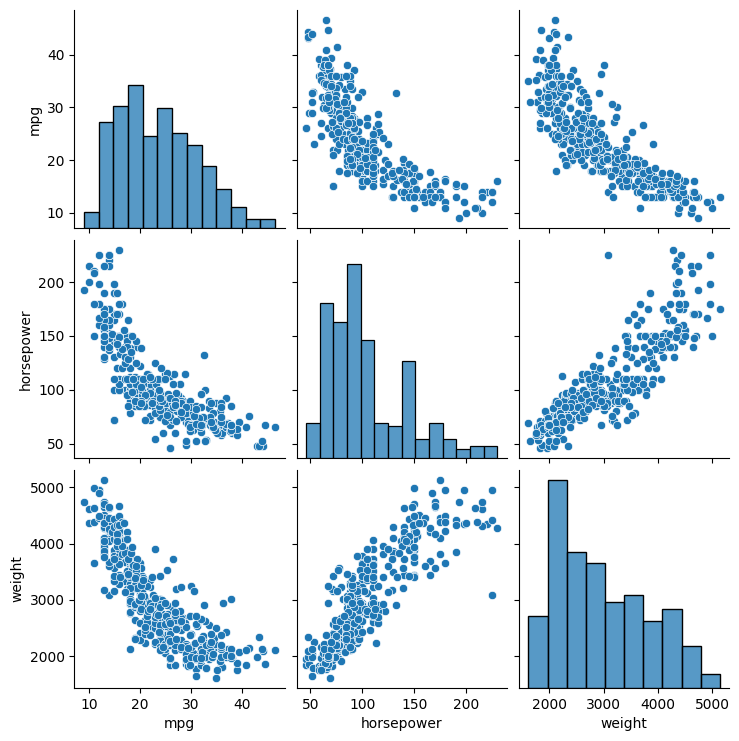

In [23]:
sns.pairplot(dts);

Para iniciar o algoritmo os elementos amostrais serão classificados em 1 dos 3 grupos:

In [24]:
dts = dts.assign(group= lambda x: 1)
for k in range(398):
  dts.loc[k, 'group'] = k % 3 + 1
dts

,mpg,horsepower,weight,name,group
0,18.0,130.0,3504,chevrolet chevelle malibu,1
1,15.0,165.0,3693,buick skylark 320,2
2,18.0,150.0,3436,plymouth satellite,3
3,16.0,150.0,3433,amc rebel sst,1
4,17.0,140.0,3449,ford torino,2
...,...,...,...,...,...
393,27.0,86.0,2790,ford mustang gl,1
394,44.0,52.0,2130,vw pickup,2
395,32.0,84.0,2295,dodge rampage,3
396,28.0,79.0,2625,ford ranger,1


Observe no gráfico abaixo que os 3 grupos estão bastante misturados, ou seja, são muito homogêneos (não existem diferenças entre os grupos).

O algoritmo será capaz de separar estes grupos?

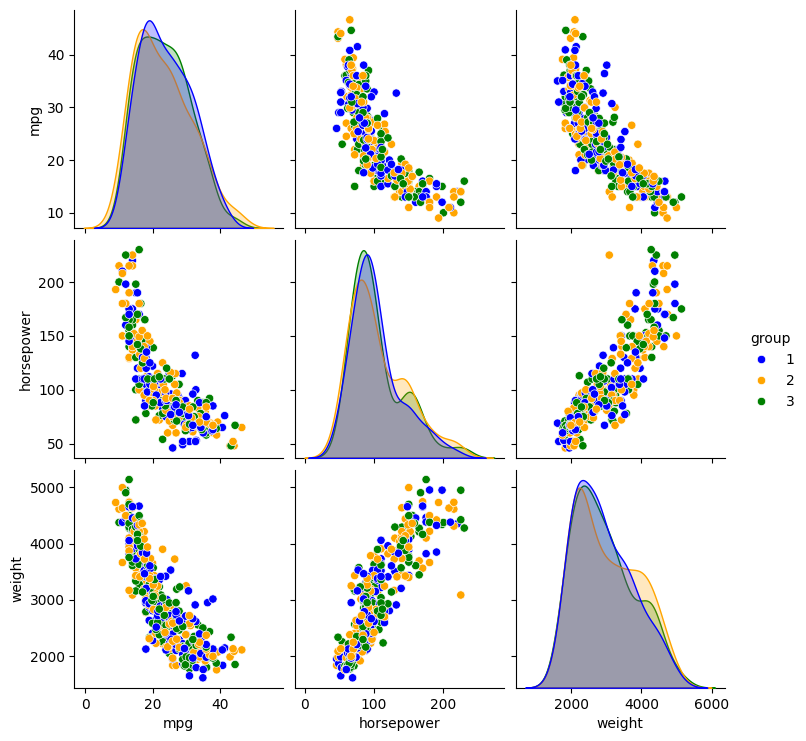

In [25]:
sns.pairplot(dts, hue= 'group', palette= { 1: 'blue', 2: 'orange', 3: 'green'});

O processo todo é representado no código seguinte.

In [26]:
while True:
  changed = False
  for k in range(dts.shape[0]):
    d1 = math.sqrt(np.sum((dts.loc[k, ['mpg', 'horsepower', 'weight']] - c1) ** 2))
    d2 = math.sqrt(np.sum((dts.loc[k, ['mpg', 'horsepower', 'weight']] - c2) ** 2))
    d3 = math.sqrt(np.sum((dts.loc[k, ['mpg', 'horsepower', 'weight']] - c3) ** 2))

    if np.argmin(np.array([d1, d2, d3])) + 1 != dts.loc[k, 'group']:
      dts.loc[k, 'group'] = np.argmin(np.array([d1, d2, d3])) + 1

      c1 = dts.loc[dts['group'] == 1, ['mpg', 'horsepower', 'weight']].mean()
      c2 = dts.loc[dts['group'] == 2, ['mpg', 'horsepower', 'weight']].mean()
      c3 = dts.loc[dts['group'] == 3, ['mpg', 'horsepower', 'weight']].mean()

      changed = True

  if not changed:
    break

Observe que, mesmo em um cenário em que os grupos inicialmente estavam homogêneos, o método é capaz de separar o conjunto de dados em diferentes grupos heterogêneos.

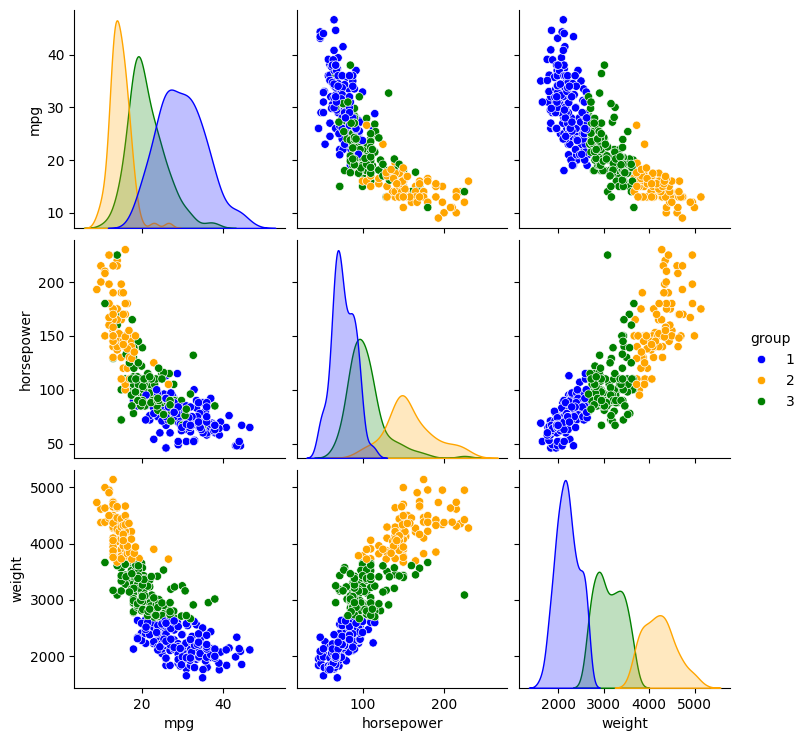

In [27]:
sns.pairplot(dts, hue= 'group', palette= { 1: 'blue', 2: 'orange', 3: 'green'});